# Neiss Datasets

## Notebook Instructions

1. **If you're using Google Colab**, select a **T4 GPU** runtime for optimal performance.
> *Note: Training will still run on CPU, but it will be significantly slower. You may need to upgrade to Colab Pro if you exceed T4 availability on the free tier.*
2. **Run the pip install cell** to install all required dependencies.
These are not automatically available when a new runtime starts
3. **Restart the runtime** after the installations complete
4. **Run the remaining notebook cells**, skipping the pip installs

In [ ]:
!pip install evaluate numpy==1.26.4

In [ ]:
# Core libraries for data handling and manipulation
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)

# Visualization tools for performance analysis
import seaborn as sns
import matplotlib.pyplot as plt

# Scikit-learn metrics for evaluating classification performance
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, precision_recall_curve

# Hugging Face datasets and transformers for model training and evaluation
from datasets import Dataset, ClassLabel, Features, Value
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding
from evaluate import load

# PyTorch for model definition and GPU acceleration
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader

In [ ]:
from google.colab import drive

In [ ]:
# Mount onto your dirve
drive.mount('/content/drive')

In [ ]:
pwd

In [ ]:
ls

In [ ]:
# Navigate to the folder where this project is on your drive
cd drive/MyDrive/NEISS/

In [ ]:
# Read in downloaded neiss data as df
df = pd.read_csv('./neiss_data/neiss_2014-2024.csv', index_col=0)

<ipython-input-18-f7123c1e4ca2>:2: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('./neiss_data/neiss_2014-2024.csv', index_col=0)


In [ ]:
df.head()

,CPSC_Case_Number,Treatment_Date,Age,Sex,Race,Other_Race,Hispanic,Body_Part,Diagnosis,Other_Diagnosis,Body_Part_2,Diagnosis_2,Other_Diagnosis_2,Disposition,Location,Fire_Involvement,Product_1,Product_2,Product_3,Alcohol,Drug,Narrative_1,Stratum,PSU,Weight
0,140103999.0,01/01/2014,32,1.0,1.0,NaN,NaN,31.0,53.0,NaN,NaN,NaN,NaN,1.0,0.0,0.0,1211.0,0.0,0.0,NaN,NaN,32 YOM CO PAIN IN THE CHEST AFTER FALLING WHIL...,S,98.0,80.0213
1,140104001.0,01/01/2014,18,1.0,1.0,NaN,NaN,82.0,51.0,NaN,NaN,NaN,NaN,1.0,1.0,2.0,910.0,0.0,0.0,NaN,NaN,18 YOM BURNED LT HAND WHILE POURING GASOLINE O...,S,98.0,80.0213
2,140104003.0,01/01/2014,31,2.0,1.0,NaN,NaN,37.0,64.0,NaN,NaN,NaN,NaN,1.0,1.0,0.0,1807.0,0.0,0.0,NaN,NaN,31 YOF STATES SHE FELL THROUGH THE BATHROOM FL...,S,98.0,80.0213
3,140104670.0,01/01/2014,53,2.0,1.0,NaN,NaN,82.0,59.0,NaN,NaN,NaN,NaN,1.0,1.0,0.0,478.0,0.0,0.0,NaN,NaN,"53YOF WASHING DISHES AT HOME, A GLASS BROKE AN...",S,29.0,80.0213
4,140104672.0,01/01/2014,23,1.0,1.0,NaN,NaN,30.0,57.0,NaN,NaN,NaN,NaN,1.0,9.0,0.0,3286.0,0.0,0.0,NaN,NaN,"23YOM RIDING AN ATV, ROLLED OVER, HURT SHOULDE...",S,29.0,80.0213


In [ ]:
len(df)

3520522

In [ ]:
# Drop records with missing Narrative_1 data
df.drop(df[df['Narrative_1'].isnull()].index, axis=0, inplace=True)

# Fine Tuning Distil-BERT

## 1. Read in hand labeled data and add informative data to the Narrative

In [ ]:
# Reading in the pre-labeled data
labeled_df = pd.read_csv("./neiss_data/labeled_data/hand_labeled_samples_487.csv")

In [ ]:
# Function to concatentate all useful information along with the narrative
def concat_narrative(row):
  body_part = row['Body_Part']
  diagnosis = row['Diagnosis']
  disposition = row['Disposition']
  product = row['Product_1']
  narrative = row['Narrative_1']

  return f"Product Code: {product}. Body Part Code: {body_part}. Diagnosis Code: {diagnosis}. Disposition Code: {disposition}. Narrative: {narrative}"

In [ ]:
labeled_df['concat_narrative'] = labeled_df.apply(concat_narrative, axis=1)
labeled_df['concat_narrative']

,concat_narrative
0,Product Code: 5040.0. Body Part Code: 87.0. Di...
1,Product Code: 1329.0. Body Part Code: 89.0. Di...
2,Product Code: 3215.0. Body Part Code: 32.0. Di...
3,Product Code: 1684.0. Body Part Code: 31.0. Di...
4,Product Code: 1871.0. Body Part Code: 37.0. Di...
...,...
482,Product Code: 1333.0. Body Part Code: 79.0. Di...
483,Product Code: 1744.0. Body Part Code: 87.0. Di...
484,Product Code: 5024.0. Body Part Code: 81.0. Di...
485,Product Code: 5022.0. Body Part Code: 35.0. Di...


## 2. Filter down original data frame to a more concentrated search

In [ ]:
# Create a filtered dataframe where only the Location codes 4 and 5 (streets and highways) are included
filtered_df = df[df['Location'].isin([4, 5])]

# ~330,000 samples remain
print(len(filtered_df))

329568


In [ ]:
# # There are many more words that we could include in the filter
# # These would be good to include later, however, for the sake of simplicity, we will only include the search words in the next cell
# search_words = [
#     "walking", "walk", "jogging", "jog", "running", "run", "on foot", "bystander",
#     "standing", "biking", "bike", "roller skating", "roller skates", "skateboarding",
#     "skateboard", "scootering", "scooter", "pedestr", "pedst", "struck by", "hit by"
# ]

# filtered_df = filtered_df[filtered_df['Narrative_1'].str.contains('|'.join(search_words), case=False, na=False)]

# len(filtered_df) # ~96,000 samples would remain

In [ ]:
# Filter df further to only include narratives that include "pedestrian" (or variation of spelling), "struck by", or "hit by"
filtered_df = filtered_df[filtered_df['Narrative_1'].str.contains('|'.join(["pedestr", "pedst", "struck by", "hit by"]), case=False, na=False)]

# ~20,000 high-priority samples
print(len(filtered_df))

19489


In [ ]:
# Excluding data that the model will be trained on
filtered_df = filtered_df[~filtered_df['Narrative_1'].isin(labeled_df['Narrative_1'])]

# There are 19,076 samples that are not in our train/validation set
# NOTE: Some data in our labeled_df are not in the filtered_df since the location codes outside of 4 and 5 were not excluded when pulling data to be hand labeled
# filtered_df contains the samples that we can run the fine-tuned model on to create the cohort
len(filtered_df)

19076

In [ ]:
# Mask that contains all of the narratives containing pedestrian
pedestrian_mask = filtered_df['Narrative_1'].str.contains('pedst|pedestr', case=False, na=False)
# Mask containing all of the narratives containing struck by/hit by
struck_hit_mask = filtered_df['Narrative_1'].str.contains('struck by|hit by', case=False, na=False)

# df containing 50 "pedestrian" samples that don't contain "struck/hit" by
group_a = filtered_df[pedestrian_mask & ~struck_hit_mask].sample(50, random_state=42)

# df containing 50 "struck/hit by" samples that dont contain "pedestrian"
group_b = filtered_df[struck_hit_mask & ~pedestrian_mask].sample(50, random_state=42)

# df containing 50 samples where both "pedestrian" and "struck/hit by" are present in the narrative
group_c = filtered_df[struck_hit_mask & pedestrian_mask].sample(50, random_state=42)

# Creating flags to test the models performance among each group
group_a['group'] = 'group_a'
group_b['group'] = 'group_b'
group_c['group'] = 'group_c'

# Holdout set containing all three groups
# For now we will only test the model on the validation set, but in future iterations, the holdout set will be hand labeled and used to evaluate model performance
holdout = pd.concat([group_a, group_b, group_c], axis=0)

In [ ]:
holdout.head()

,CPSC_Case_Number,Treatment_Date,Age,Sex,Race,Other_Race,Hispanic,Body_Part,Diagnosis,Other_Diagnosis,Body_Part_2,Diagnosis_2,Other_Diagnosis_2,Disposition,Location,Fire_Involvement,Product_1,Product_2,Product_3,Alcohol,Drug,Narrative_1,Stratum,PSU,Weight,group
2995637,220649382.0,05/18/2022,17,2.0,2.0,NaN,0.0,30.0,55.0,NaN,NaN,NaN,NaN,1.0,4.0,0.0,5040.0,0.0,0.0,0.0,0.0,"17YOF PRESENTED TO ED C/O PEDESTRAIN STRUCK, P...",V,57.0,18.1791,group_a
964545,160906268.0,05/17/2016,43,1.0,0.0,NaN,NaN,75.0,62.0,NaN,NaN,NaN,NaN,1.0,4.0,0.0,5040.0,0.0,0.0,NaN,NaN,"43YOM W/CHI,FACIAL CONT,ABRAS & PAIN TO ELBOW ...",V,41.0,14.6504,group_a
3253168,230424553.0,04/07/2023,23,1.0,5.0,NaN,2.0,76.0,57.0,NaN,88.0,59.0,NaN,1.0,4.0,0.0,1333.0,0.0,0.0,0.0,0.0,23YOM PATIENT WAS ON HIS SKATEBOARD ON HIS WAY...,S,47.0,76.8216,group_a
3313305,230638234.0,06/10/2023,53,1.0,2.0,NaN,2.0,87.0,71.0,OSTEOPHYTE,NaN,NaN,NaN,1.0,4.0,0.0,5040.0,0.0,0.0,0.0,0.0,53YOM BROUGHT IN BY EMS WITH CC OF LEFT FOREAR...,M,76.0,79.7644,group_a
1316897,170817237.0,08/03/2017,25,1.0,2.0,NaN,NaN,93.0,57.0,NaN,NaN,NaN,NaN,1.0,5.0,0.0,1211.0,0.0,0.0,NaN,NaN,"25YOM S/P PEDESTRIAN VS CAR ACCID,5PM TODAY,PT...",L,3.0,67.2099,group_a


## 3. Train the model

In [ ]:
labeled_df.head(3)

,Narrative_1,Human Label,CPSC_Case_Number,Treatment_Date,Age,Sex,Race,Other_Race,Hispanic,Body_Part,Diagnosis,Other_Diagnosis,Body_Part_2,Diagnosis_2,Other_Diagnosis_2,Disposition,Location,Fire_Involvement,Product_1,Product_2,Product_3,Alcohol,Drug,Stratum,PSU,Weight,concat_narrative
0,16YOM PRESENTS AFTER BEING PEDESTRIAN STRUCK W...,0,201227717.0,10/06/2020,16,1.0,1.0,NaN,2.0,87.0,71.0,NS,NaN,NaN,NaN,1.0,4.0,0.0,5040.0,0.0,0.0,0.0,0.0,V,57.0,15.9992,Product Code: 5040.0. Body Part Code: 87.0. Di...
1,55 YOM DX NECK AND BACK PAIN - S/P PT PEDESTRI...,0,160206064.0,01/04/2016,55,1.0,2.0,NaN,NaN,89.0,71.0,NECK/BACK PAIN,NaN,NaN,NaN,1.0,4.0,0.0,1329.0,0.0,0.0,NaN,NaN,V,57.0,16.1154,Product Code: 1329.0. Body Part Code: 89.0. Di...
2,23YOM WITH ELBOW PAIN AFTER RIDING MOPED TO WO...,0,231242909.0,12/13/2023,23,1.0,2.0,NaN,2.0,32.0,57.0,NaN,NaN,NaN,NaN,1.0,4.0,0.0,3215.0,0.0,0.0,0.0,0.0,L,51.0,55.4417,Product Code: 3215.0. Body Part Code: 32.0. Di...


In [ ]:
# This is the cell that is affected by the numpy downgrade. If you run into an issue here, restart your runtime session and run the cells in the notebook again

# In order to stratify by the labels, you must set them as features in the dataset
features = Features({
    'text': Value('string'),
    'labels': ClassLabel(names=["Not Pedestrian", "Pedestrian"])
})

# Create a huggingface dataset only containing the text (concat_narrative) and the labels (Human Label)
dataset = Dataset.from_pandas(
    df=labeled_df.rename(columns={'concat_narrative':'text', 'Human Label': 'labels'}).reset_index(drop=True)[['labels','text']],
    features=features
)

# Split the data into a train and validation set, stratifying by the labels
dataset = dataset.train_test_split(test_size=0.2, seed=42, stratify_by_column='labels')

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 389
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 98
    })
})

In [ ]:
pretrained_model = "bert-base-uncased" # Set the pretrained model that will be used
tokenizer = AutoTokenizer.from_pretrained(pretrained_model) # Initialize the tokenizer

# defining the tokenization function
def tokenize(sample):
    return tokenizer(
        sample['text'],
        truncation=True
    )

# Tokenize the dataset saving it as results
results = dataset.map(tokenize, batched=True)

Map:   0%|          | 0/389 [00:00<?, ? examples/s]

Map:   0%|          | 0/98 [00:00<?, ? examples/s]

In [ ]:
id2label = {0: "Not Pedestrian", 1: "Pedestrian"}
label2id = {"Not Pedestrian":0, "Pedestrian": 1}

# Setting up the classification head with the two labels
model = AutoModelForSequenceClassification.from_pretrained(
    pretrained_model,
    num_labels = 2,
    id2label = id2label,
    label2id = label2id
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Load evaluation metrics
accuracy = load("accuracy")
precision = load("precision")
recall = load("recall")
f1_score = load("f1")

# Define a metric function for evaluation
def compute_metrics(p):
    pred = np.argmax(p.predictions, axis=1)
    labels = p.label_ids

    return {
        "accuracy": accuracy.compute(predictions=pred, references=labels)['accuracy'],
        "precision": precision.compute(predictions=pred, references=labels, average='binary')['precision'],
        "recall": recall.compute(predictions=pred, references=labels, average='binary')['recall'],
        "f1": f1_score.compute(predictions=pred, references=labels, average='binary')['f1'],
    }

In [ ]:
# Hyperparameters
lr = 0.00004 # Size of optimization step
batch_size = 4 # number of examples processed per optimization step
num_epochs = 10 # number of times the model runs through training data
weight_decay = 0.1

# Defining the training arguments
training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=lr,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    weight_decay=weight_decay,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_only_model=True,
    load_best_model_at_end=False, # If False we will have to load the best model by hand based on the model checkpoints in the results directory
    save_total_limit=10,
    report_to='tensorboard',
    do_eval=True,
    logging_strategy='epoch',
    overwrite_output_dir=True,
    metric_for_best_model="precision", # We care most about precision for defining a cohort.
    label_smoothing_factor=0.1 # To help with not having the model be overly confident in its predictions
)

In [ ]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = Trainer(
    model=model,
    args=training_args, # hyperparameters
    train_dataset=results['train'], # training data
    eval_dataset=results['test'], # validation data
    tokenizer=tokenizer, # The narratives from the training and testing sets are already pre-tokenized. Passing the tokenizer here is primarily used for decoding predictions
    data_collator=data_collator, # Dynamically pads each tokenized batch
    compute_metrics=compute_metrics # Runs on HuggingFace's EvalPrediction object (see compute metrics notes for how this works)
)

<ipython-input-61-7be6b800cbc2>:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
# Train the model
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.623900,0.458094,0.857143,0.877193,0.877193,0.877193
2,0.468800,0.402983,0.897959,0.885246,0.947368,0.915254
3,0.369200,0.439441,0.908163,0.900000,0.947368,0.923077
4,0.267900,0.481115,0.867347,0.833333,0.964912,0.894309
5,0.235800,0.447582,0.908163,0.875000,0.982456,0.925620
6,0.223700,0.410084,0.908163,0.900000,0.947368,0.923077
7,0.216500,0.400180,0.918367,0.915254,0.947368,0.931034
8,0.206300,0.386306,0.928571,0.916667,0.964912,0.940171
9,0.205200,0.383762,0.928571,0.903226,0.982456,0.941176
10,0.206000,0.386779,0.928571,0.903226,0.982456,0.941176


TrainOutput(global_step=980, training_loss=0.30233176679027324, metrics={'train_runtime': 177.6897, 'train_samples_per_second': 21.892, 'train_steps_per_second': 5.515, 'total_flos': 198903735631680.0, 'train_loss': 0.30233176679027324, 'epoch': 10.0})

In [ ]:
# CUDA is a software layer that gives direct access to the GPU's virtual instruction set and parallel computational elements for the execution of compute kernels
torch.cuda.is_available()

True

In [ ]:
# Best model based on the metric_for_best_model argument in the TrainingArguments
print(trainer.state.best_model_checkpoint)

./results/checkpoint-784


In [ ]:
# replace with whatever checkpoint you decide
# This will change after each new model training

model = AutoModelForSequenceClassification.from_pretrained("./results/checkpoint-784")

## Sanity Check
Making sure that the model performs well on the training set

We would expect this to be at or near 100% accuracy

In [ ]:
# Set the model to evaluation mode (disables dropout and gradient tracking for layers that behave differently during training)
model.eval()

# Move the model to Compute Unified Device Architecture (cuda), a parallel computing platform and application programming interface (API) model created by NVIDIA
model.to('cuda')

train_loader = DataLoader(
    results['train'].remove_columns(['text']),
    batch_size=8,
    collate_fn=data_collator
)

all_preds = []
all_labels = []

with torch.no_grad(): # Does not track gradients for evaluation
  for batch in train_loader:
    batch = {k: v.to('cuda') for k, v in batch.items()}
    outputs = model(**batch)
    preds = torch.argmax(outputs.logits, dim=1)

    all_preds.extend(preds.cpu().numpy())
    all_labels.extend(batch['labels'].cpu().numpy())

print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       161
           1       1.00      1.00      1.00       228

    accuracy                           1.00       389
   macro avg       1.00      1.00      1.00       389
weighted avg       1.00      1.00      1.00       389



## Evaluate Model on Test Set (Argmax)

In [ ]:
# Set the model to evaluation mode (disables dropout and gradient tracking for layers that behave differently during training)
model.eval()

# Move the model to Compute Unified Device Architecture (cuda), a parallel computing platform and application programming interface (API) model created by NVIDIA
model.to('cuda')

# Loading the data to be batched and collated the same way during eval as it was during training
train_loader = DataLoader(
    results['test'].remove_columns(['text']),
    batch_size=8,
    collate_fn=data_collator
)

all_preds = []
all_labels = []

with torch.no_grad(): # Does not track gradients for evaluation
  for batch in train_loader:
    # Move each tensor in the batch to the GPU
    batch = {k: v.to('cuda') for k, v in batch.items()}

    # Run the model forward pass and get output logits
    outputs = model(**batch)

    # Select the index of the highest logit as the predicted class
    preds = torch.argmax(outputs.logits, dim=1)

    all_preds.extend(preds.cpu().numpy())
    all_labels.extend(batch['labels'].cpu().numpy())

print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

           0       0.95      0.88      0.91        41
           1       0.92      0.96      0.94        57

    accuracy                           0.93        98
   macro avg       0.93      0.92      0.93        98
weighted avg       0.93      0.93      0.93        98



## Evaluate Model on Test Set (Softmax)

In [ ]:
# Set the model to evaluation mode (disables dropout and gradient tracking for layers that behave differently during training)
model.eval()

# Move the model to Compute Unified Device Architecture (cuda), a parallel computing platform and application programming interface (API) model created by NVIDIA
model.to('cuda')

# Loading the data to be batched and collated the same way during eval as it was during training
train_loader = DataLoader(
    results['test'].remove_columns(['text']),
    batch_size=8,
    collate_fn=data_collator
)

y_proba = []
y_true = []

with torch.no_grad(): # Does not track gradients for evaluation
  for batch in train_loader:
    # Move each tensor in the batch to the GPU
    batch = {k: v.to('cuda') for k, v in batch.items()}

    # Run the model forward pass and get output logits
    outputs = model(**batch)

    # Select the index of the highest logit as the predicted class
    probs = F.softmax(outputs.logits, dim=1)[:, 1] # Takes the 0th batch and the 1st predicted probability (pedestrian) from the tensor

    y_proba.extend(probs.cpu().numpy())
    y_true.extend(batch['labels'].cpu().numpy())

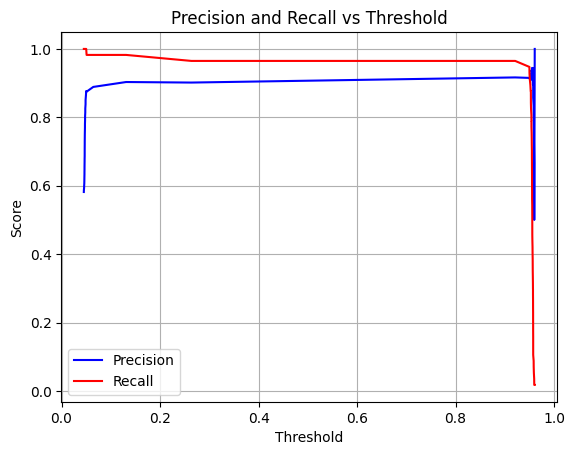

In [ ]:
precision, recall, thresholds = precision_recall_curve(y_true, y_proba)
# Plot precision and recall vs threshold
plt.plot(thresholds, precision[:-1], label="Precision", color="blue")
plt.plot(thresholds, recall[:-1], label="Recall", color="red")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision and Recall vs Threshold")
plt.legend()
plt.grid(True)

In [ ]:
# Performance of model when we set the cutoff for the probability to be 0.90
# Note, this current model is predicting very confidently, which is why we have to set the cutoff to be so high before we notice any change to the metrics
print(classification_report(y_true, (np.array(y_proba)>0.90).astype(int)))

              precision    recall  f1-score   support

           0       0.95      0.88      0.91        41
           1       0.92      0.96      0.94        57

    accuracy                           0.93        98
   macro avg       0.93      0.92      0.93        98
weighted avg       0.93      0.93      0.93        98



## Load Best Model from Previous Training

Authenticate with the Hugging Face Hub and load the saved model and tokenizer.

In [ ]:
from huggingface_hub import notebook_login

In [ ]:
notebook_login()

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained('DevJGraham/neiss_clf_bert_uncased')

config.json:   0%|          | 0.00/823 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('DevJGraham/neiss_clf_bert_uncased')

tokenizer_config.json:   0%|          | 0.00/1.22k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

## Evaluate Best Model on Test Set

Run the loaded model on the test set using the same evaluation setup as training, and generate classification metrics.

In [ ]:
# Set the model to evaluation mode (disables dropout and gradient tracking for layers that behave differently during training)
model.eval()

# Move the model to Compute Unified Device Architecture (cuda), a parallel computing platform and application programming interface (API) model created by NVIDIA
model.to('cuda')

# Loading the data to be batched and collated the same way during eval as it was during training
train_loader = DataLoader(
    results['test'].remove_columns(['text']),
    batch_size=8,
    collate_fn=data_collator
)

all_preds = []
all_labels = []

with torch.no_grad(): # Does not track gradients for evaluation
  for batch in train_loader:
    # Move each tensor in the batch to the GPU
    batch = {k: v.to('cuda') for k, v in batch.items()}

    # Run the model forward pass and get output logits
    outputs = model(**batch)

    # Select the index of the highest logit as the predicted class
    preds = torch.argmax(outputs.logits, dim=1)

    all_preds.extend(preds.cpu().numpy())
    all_labels.extend(batch['labels'].cpu().numpy())

print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

           0       0.95      0.90      0.93        41
           1       0.93      0.96      0.95        57

    accuracy                           0.94        98
   macro avg       0.94      0.93      0.94        98
weighted avg       0.94      0.94      0.94        98

